In [115]:
import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

In [116]:
import time
from sklearn.manifold import TSNE
from tqdm import tqdm

In [117]:
import pickle
import json
import string

In [118]:
import urllib.request

In [119]:
url = "https://cs.stanford.edu/people/karpathy/char-rnn/warpeace_input.txt"

response = urllib.request.urlopen(url)
text = response.read().decode("utf-8")

In [120]:
%pip install nltk


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [121]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [122]:
def preprocess_text(text):
    tokens = nltk.tokenize.word_tokenize(text.lower())
    words = [word for word in tokens if word.isalpha()]
    return words

words = preprocess_text(text)

In [123]:
print(words[:10])

['well', 'prince', 'so', 'genoa', 'and', 'lucca', 'are', 'now', 'just', 'family']


In [124]:
vocab = sorted(set(words))  
vocab += ['unknown token', 'padding']
vocab_size = len(vocab)
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for idx, word in enumerate(vocab)}

In [125]:
class RNNTextGenerator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(RNNTextGenerator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim,batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x) 
        x = self.fc(x[:, -1, :])
        return x

In [126]:
context_length = 5

def prepare_data(words, context_length):
    X, y = [], []
    for i in range(context_length, len(words)):
        X.append([word_to_idx[word] for word in words[i-context_length:i]])
        y.append(word_to_idx[words[i]])
    return np.array(X), np.array(y)


X, y = prepare_data(words, context_length)
print(X.shape, y.shape)

(560989, 5) (560989,)


In [127]:
embedding_dim = 64
hidden_dim = 128
model = RNNTextGenerator(vocab_size, embedding_dim, hidden_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [128]:
import tensorflow as tf

In [129]:
epochs = 10
batch_size = 32
train_data = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.long), torch.tensor(y, dtype=torch.long))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [132]:
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/10: 100%|██████████| 17531/17531 [11:26<00:00, 25.52it/s]


Epoch 1, Loss: 5.9625


Epoch 2/10: 100%|██████████| 17531/17531 [22:50<00:00, 12.79it/s]  


Epoch 2, Loss: 5.4424


Epoch 3/10: 100%|██████████| 17531/17531 [12:11<00:00, 23.97it/s]


Epoch 3, Loss: 5.2357


Epoch 4/10: 100%|██████████| 17531/17531 [10:30<00:00, 27.78it/s]


Epoch 4, Loss: 5.0946


Epoch 5/10: 100%|██████████| 17531/17531 [10:31<00:00, 27.76it/s]


Epoch 5, Loss: 4.9767


Epoch 6/10: 100%|██████████| 17531/17531 [10:46<00:00, 27.12it/s]


Epoch 6, Loss: 4.8831


Epoch 7/10: 100%|██████████| 17531/17531 [12:14<00:00, 23.86it/s]


Epoch 7, Loss: 4.7983


Epoch 8/10: 100%|██████████| 17531/17531 [19:33<00:00, 14.94it/s]


Epoch 8, Loss: 4.7249


Epoch 9/10: 100%|██████████| 17531/17531 [14:10<00:00, 20.62it/s] 


Epoch 9, Loss: 4.6617


Epoch 10/10: 100%|██████████| 17531/17531 [10:11<00:00, 28.65it/s]

Epoch 10, Loss: 4.6053


In [133]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'rnn_text_generator.pth')
with open('rnn_text_generator.pkl', 'wb') as f:
    pickle.dump(model, f)

vocab_data = {
    "word_to_idx": word_to_idx,
    "idx_to_word": idx_to_word
}
with open('vocab.json', 'w') as f:
    json.dump(vocab_data, f)

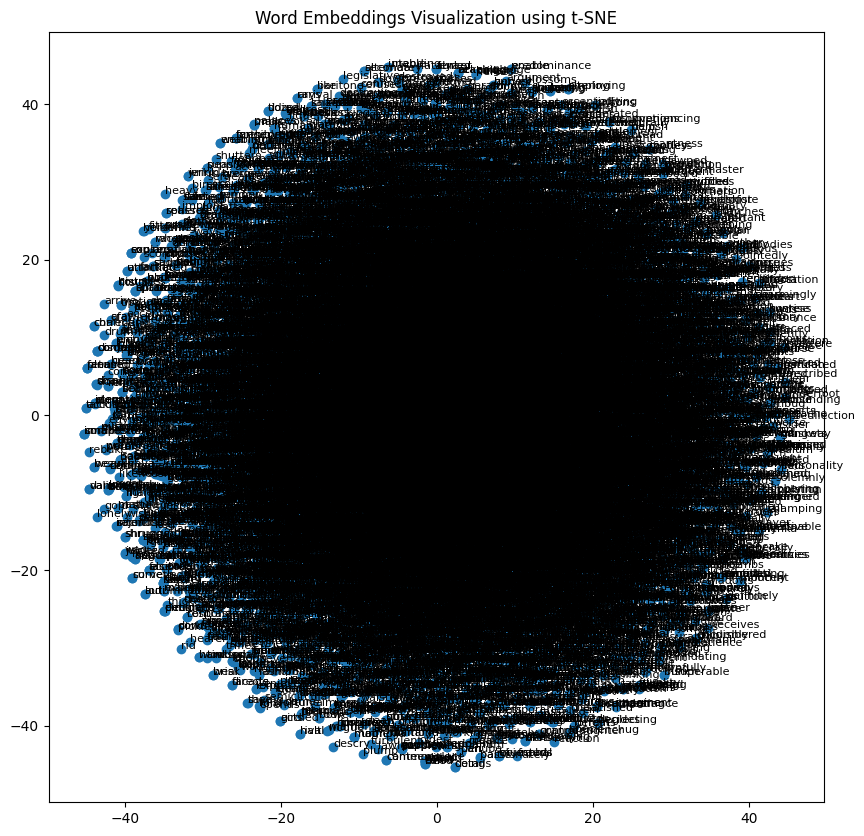

In [134]:
embeddings = model.embedding.weight.detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
for i, word in enumerate(vocab):
    plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8)
plt.title("Word Embeddings Visualization using t-SNE")
plt.show()

In [36]:
import torch
import json
import nltk
from torch import nn
import pickle

model_path = "rnn_text_generator.pkl"
vocab_path = "vocab.json"

# Load the model
with open(model_path, "rb") as f:
    model = pickle.load(f)
model.eval()  

with open(vocab_path, "r") as f:
    vocab_data = json.load(f)
word_to_idx = vocab_data["word_to_idx"]
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

def preprocess_text(sentence):
    # Tokenize and clean sentence
    tokens = nltk.tokenize.word_tokenize(sentence.lower())
    words = [word for word in tokens if word.isalpha()]
    return words

def predict_next_word(sentence, context_length=5):
    words = preprocess_text(sentence)
    
    # Pad with 'padding' if length is less than context_length
    if len(words) < context_length:
        words = ['padding'] * (context_length - len(words)) + words

    # Convert words to indices
    input_indices = [word_to_idx.get(word, word_to_idx['unknown token']) for word in words[-context_length:]]
    input_tensor = torch.tensor([input_indices], dtype=torch.long)

    # Get the predicted next word
    with torch.no_grad():
        output = model(input_tensor)
        predicted_idx = output.argmax(dim=-1).item()
    
    # Fetch the predicted word
    predicted_word = idx_to_word.get(predicted_idx, 'unknown token')
    return predicted_word

# Test prediction
sentence = "What is your "
print(f"The next word prediction for '{sentence}': {predict_next_word(sentence)}")

The next word prediction for 'What is your ': excellency


In [37]:
def predict_next_k_words(model, sentence, word_to_idx, idx_to_word, context_length=5, k=3):
    words = preprocess_text(sentence)
    
    if len(words) < context_length:
        words = ['padding'] * (context_length - len(words)) + words
    
    predicted_words = []
    
    for _ in range(k):
        input_indices = [word_to_idx.get(word, word_to_idx['unknown token']) for word in words[-context_length:]]
        input_tensor = torch.tensor([input_indices], dtype=torch.long)
        
        with torch.no_grad():
            output = model(input_tensor)
            predicted_idx = output.argmax(dim=-1).item()
            predicted_word = idx_to_word[predicted_idx]
        
        predicted_words.append(predicted_word)
        words.append(predicted_word)  
    
    return predicted_words

sentence = "I want to say you "
predicted_words = predict_next_k_words(model, sentence, word_to_idx, idx_to_word, context_length=5, k=3)
print(f"The next 3 words for '{sentence}': {' '.join(predicted_words)}")


The next 3 words for 'I want to say you ': are the same
